<a href="https://colab.research.google.com/github/natomendes/transfer-learning-with-fine-tuning/blob/main/transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INSTALAÇÃO E IMPORTAÇÃO DAS BIBLIOTECAS

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import requests
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import shutil
import random
from PIL import Image

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.18.0
Keras version: 3.8.0


DOWNLOAD E PREPARAÇÃO DO DATASET

In [2]:
def download_and_extract_dataset():
    """
    Download do dataset Cats vs Dogs da Microsoft e extração dos arquivos
    """
    # dataset URL
    url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"

    # File name
    filename = "kagglecatsanddogs_5340.zip"

    print("Iniciando download do dataset...")

    # Downloading file...
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    with open(filename, 'wb') as file:
        downloaded = 0
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                file.write(chunk)
                downloaded += len(chunk)
                if total_size > 0:
                    percent = (downloaded / total_size) * 100
                    print(f"\rProgress: {percent:.1f}%", end='')

    print(f"\nDownload finished! File saved as: {filename}")

    # Extracting file...
    print("Extracting files...")
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall()

    print("Extration finished!")

    # Set diretories structure
    base_dir = 'PetImages'
    cat_dir = os.path.join(base_dir, 'Cat')
    dog_dir = os.path.join(base_dir, 'Dog')

    print(f"Total de imagens de gatos: {len(os.listdir(cat_dir))}")
    print(f"Total de imagens de cachorros: {len(os.listdir(dog_dir))}")

    return base_dir

# Uncomment this line on the first run
base_dir = download_and_extract_dataset()

# Comment this line on the fist run
# base_dir = 'PetImages'

Iniciando download do dataset...
Progress: 100.0%
Download concluído! Arquivo salvo como: kagglecatsanddogs_5340.zip
Extraindo arquivos...
Extração concluída!
Total de imagens de gatos: 12501
Total de imagens de cachorros: 12501


In [3]:
def definitive_clean_for_grayscale(base_dir):
    """
    Scans a directory using TensorFlow's grayscale decoder and removes
    any file that causes an error. This is the most reliable cleaning method.
    """
    print(f"--- Starting Definitive Grayscale Scan on {base_dir} ---")
    removed_count = 0
    for folder_name in ("Cat", "Dog"):
        class_dir = os.path.join(base_dir, folder_name)
        if not os.path.isdir(class_dir):
            print(f"Warning: Directory not found: {class_dir}")
            continue

        print(f"Scanning folder: {class_dir}")
        for filename in os.listdir(class_dir):
            file_path = os.path.join(class_dir, filename)
            try:
                # This is the crucial part:
                # 1. Read the file into memory as bytes.
                img_bytes = tf.io.read_file(file_path)
                # 2. Try to decode it with 1 channel (grayscale), just like the training pipeline will.
                tf.io.decode_image(img_bytes, channels=1)

            except tf.errors.InvalidArgumentError:
                # This catches the exact error you are seeing.
                print(f"DELETING corrupted file: {file_path}")
                os.remove(file_path)
                removed_count += 1
            except Exception as e:
                # Catch any other unexpected errors
                print(f"Skipping file with other error {file_path}: {e}")

    print(f"\n--- Scan Complete. Removed {removed_count} incompatible files. ---")

# IMPORTANT: Run this on your main, original dataset folder
base_dir = 'PetImages'
definitive_clean_for_grayscale(base_dir)

--- Starting Definitive Grayscale Scan on PetImages ---
Scanning folder: PetImages/Cat
DELETING corrupted file: PetImages/Cat/8470.jpg
DELETING corrupted file: PetImages/Cat/Thumbs.db
DELETING corrupted file: PetImages/Cat/11874.jpg
DELETING corrupted file: PetImages/Cat/11565.jpg
DELETING corrupted file: PetImages/Cat/3161.jpg
DELETING corrupted file: PetImages/Cat/9565.jpg
DELETING corrupted file: PetImages/Cat/9100.jpg
DELETING corrupted file: PetImages/Cat/10874.jpg
DELETING corrupted file: PetImages/Cat/1267.jpg
DELETING corrupted file: PetImages/Cat/4000.jpg
DELETING corrupted file: PetImages/Cat/10073.jpg
DELETING corrupted file: PetImages/Cat/5819.jpg
DELETING corrupted file: PetImages/Cat/9778.jpg
DELETING corrupted file: PetImages/Cat/11086.jpg
DELETING corrupted file: PetImages/Cat/666.jpg
DELETING corrupted file: PetImages/Cat/850.jpg
DELETING corrupted file: PetImages/Cat/5614.jpg
DELETING corrupted file: PetImages/Cat/7642.jpg
DELETING corrupted file: PetImages/Cat/1936.j

ORGANIZAÇÃO DOS DADOS EM TREINO E VALIDAÇÃO

In [5]:
def organize_dataset_and_clean(base_dir, train_ratio=0.8, max_images_per_class=2000):
    """
    Organizes the dataset and cleans it by finding and removing corrupted images
    from the source directory.
    """
    train_dir = 'train'
    validation_dir = 'validation'

    # Remove and recreate train/validation directories
    for directory in [train_dir, validation_dir]:
        if os.path.exists(directory):
            shutil.rmtree(directory)
    os.makedirs(os.path.join(train_dir, 'cats'), exist_ok=True)
    os.makedirs(os.path.join(train_dir, 'dogs'), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, 'cats'), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, 'dogs'), exist_ok=True)

    def copy_and_clean_files(source_dir, dest_train, dest_val, class_name):
        """Inner function to process files for a single class."""
        files = os.listdir(source_dir)
        valid_files = []

        print(f"Scanning and cleaning {class_name} images in {source_dir}...")
        for file in files:
            img_path = os.path.join(source_dir, file)
            try:
                # Attempt to open and verify the image file
                img = Image.open(img_path)
                img.verify() # Verifies image integrity. Throws an exception if corrupt.
                valid_files.append(file)
            except Exception as e:
                # If the file is corrupt, print a message and remove it.
                print(f"Found and removing corrupted file: {img_path} | Reason: {e}")
                try:
                    os.remove(img_path)
                except OSError as remove_error:
                    print(f"Error trying to remove {img_path}: {remove_error}")

        # Proceed with the limited, shuffled valid files
        random.shuffle(valid_files)
        limited_files = valid_files[:max_images_per_class]

        split_idx = int(len(limited_files) * train_ratio)
        train_files = limited_files[:split_idx]
        val_files = limited_files[split_idx:]

        # Copy files to train and validation directories
        for file in train_files:
            shutil.copy2(os.path.join(source_dir, file), os.path.join(dest_train, file))
        for file in val_files:
            shutil.copy2(os.path.join(source_dir, file), os.path.join(dest_val, file))

        print(f"{class_name}: {len(train_files)} train, {len(val_files)} validation")

    print(f"Organizing dataset with a max of {max_images_per_class} images per class...")
    # Process cats
    copy_and_clean_files(os.path.join(base_dir, 'Cat'), os.path.join(train_dir, 'cats'),
                         os.path.join(validation_dir, 'cats'), 'Cats')
    # Process dogs
    copy_and_clean_files(os.path.join(base_dir, 'Dog'), os.path.join(train_dir, 'dogs'),
                         os.path.join(validation_dir, 'dogs'), 'Dogs')

    return train_dir, validation_dir

# --- HOW TO USE IT ---
# base_dir = 'PetImages'
# Call this function ONCE to clean your source data and create the train/val sets.
train_dir, validation_dir = organize_dataset_and_clean(base_dir, max_images_per_class=10000)

# For all subsequent runs, just define the paths to avoid re-running the process:
# train_dir = 'train'
# validation_dir = 'validation'

Organizing dataset with a max of 10000 images per class...
Scanning and cleaning Cats images in PetImages/Cat...
Cats: 8000 train, 2000 validation
Scanning and cleaning Dogs images in PetImages/Dog...
Dogs: 8000 train, 2000 validation


CONFIGURAÇÃO DOS GERADORES DE DADOS

In [6]:
# Parâmetros
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32# --- NEW AND IMPROVED DATA PIPELINE ---
AUTOTUNE = tf.data.AUTOTUNE

# Create the datasets using the modern utility
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='bilinear',
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='bilinear',
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

# Optimize for performance
print("Optimizing data pipelines...")
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("Data pipelines are ready! 🚀")

Found 16000 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.
Optimizing data pipelines...
Data pipelines are ready! 🚀


VISUALIZAÇÃO DE ALGUMAS IMAGENS DO DATASET

Exemplos de imagens do dataset:


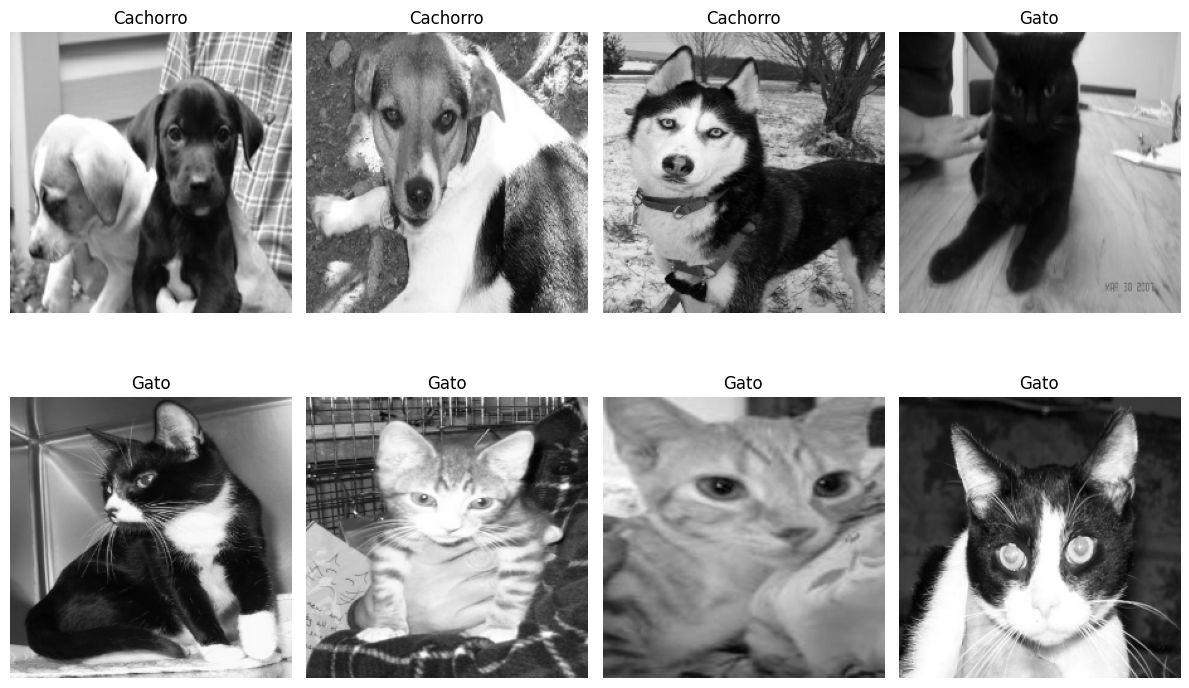

In [7]:
import matplotlib.pyplot as plt

def plot_sample_images(dataset, num_images=8):
    """
    Plots sample images from a tf.data.Dataset.
    """
    plt.figure(figsize=(12, 8))

    # 1. Get one batch of images from the dataset iterator
    images, labels = next(iter(dataset))

    for i in range(min(num_images, len(images))):
        ax = plt.subplot(2, 4, i + 1)

        # 2. Convert tensor to numpy array and set colormap to gray
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')

        class_name = 'Cachorro' if labels[i] == 1 else 'Gato'
        plt.title(class_name)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Now you can call it with your new dataset
print("Exemplos de imagens do dataset:")
plot_sample_images(train_dataset)

CRIAÇÃO DO MODELO COM TRANSFER LEARNING

In [8]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

def create_transfer_learning_model():
    """
    Cria modelo usando Transfer Learning com VGG16 adaptado para grayscale
    """
    # Carregar modelo pré-treinado VGG16 (sem as camadas superiores)
    vgg16_base = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )

    # 2. Freeze the entire VGG16 base. This is the correct way.
    vgg16_base.trainable = False

    # Criar um novo modelo com uma camada de entrada para grayscale
    inp = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))

    # **NEW:** Add rescaling layer for normalization
    x = layers.Rescaling(1./255)(inp)

    # Get a reference to the Conv2D layer
    conv_layer = layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding='same',
        activation='relu',
        name='block1_conv1_grayscale'
    )
    x = conv_layer(x)


    # Copiar os pesos da primeira camada convolucional do VGG16
    # e adaptá-los para a entrada em escala de cinza (média dos canais)
    original_weights = vgg16_base.get_layer('block1_conv1').get_weights()
    new_weights = [np.mean(original_weights[0], axis=2, keepdims=True), original_weights[1]]
    # Set the weights on the layer, not the tensor
    conv_layer.set_weights(new_weights)

    # Adicionar as camadas restantes do VGG16
    for layer in vgg16_base.layers[2:]:
        x = layer(x)

    # Adicionar a cabeça de classificação
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    # Criar o modelo final
    model = keras.Model(inputs=inp, outputs=output)

    return model, vgg16_base

# Criar modelo
model, base_model = create_transfer_learning_model()

# Visualizar arquitetura
model.summary()

print(f"\nNúmero de camadas no modelo base: {len(base_model.layers)}")
print(f"Número de camadas treináveis: {len([layer for layer in model.layers if layer.trainable])}")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1_grayscale (Conv2D) │ (None, 224, 224, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,779,329 (56.38 MB)

 Trainable params: 66,433 (259.50 KB)

 Non-trainable params: 14,712,896 (56.13 MB)


Número de camadas no modelo base: 19
Número de camadas treináveis: 8


COMPILAÇÃO DO MODELO

In [9]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

CALLBACKS PARA TREINAMENTO

In [10]:
# Early stopping para evitar overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Redução da learning rate quando não há melhoria
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7
)

TREINAMENTO DO MODELO

In [11]:
EPOCHS_PHASE1 = 10

history_phase1 = model.fit(
    train_dataset,
    epochs=EPOCHS_PHASE1,
    validation_data=validation_dataset,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Primeira fase de treinamento concluída!")

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 122s 153ms/step - accuracy: 0.5751 - loss: 0.6980 - val_accuracy: 0.8340 - val_loss: 0.4144 - learning_rate: 0.0010
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 83s 122ms/step - accuracy: 0.7761 - loss: 0.4666 - val_accuracy: 0.8905 - val_loss: 0.2656 - learning_rate: 0.0010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 60s 119ms/step - accuracy: 0.8351 - loss: 0.3580 - val_accuracy: 0.9200 - val_loss: 0.2000 - learning_rate: 0.0010
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 59s 119ms/step - accuracy: 0.8666 - loss: 0.3152 - val_accuracy: 0.9300 - val_loss: 0.1860 - learning_rate: 0.0010
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 64s 128ms/step - accuracy: 0.8793 - loss: 0.2763 - val_accuracy: 0.9370 - val_loss: 0.1674 - learning_rate: 0.0010
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 78s 120ms/step - accuracy: 0.8875 - loss: 0.2600 - val_accuracy: 0.9427 - val_loss: 0.1571 - learning_rate: 0.0010
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 120ms/step - accuracy: 0.

FINE-TUNING

In [12]:
# Descongelar algumas camadas do modelo base para fine-tuning
base_model.trainable = True

# Congelar as primeiras camadas, permitir treino apenas das últimas
fine_tune_at = len(base_model.layers) - 4

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompilar com learning rate menor para fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001/10),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(f"Camadas treináveis após fine-tuning: {len([layer for layer in model.layers if layer.trainable])}")

# Segunda fase de treinamento
EPOCHS_PHASE2 = 10

print(f"Configuração do fine-tuning:")
print(f"- Épocas fase 2: {EPOCHS_PHASE2}")

Camadas treináveis após fine-tuning: 12
Configuração do fine-tuning:
- Épocas fase 2: 10


In [13]:
print("Iniciando Fine-tuning...")

history_phase2 = model.fit(
    train_dataset,
    epochs=EPOCHS_PHASE2,
    validation_data=validation_dataset,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Iniciando Fine-tuning...
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 71s 126ms/step - accuracy: 0.9379 - loss: 0.1619 - val_accuracy: 0.9640 - val_loss: 0.0923 - learning_rate: 1.0000e-05
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 61s 121ms/step - accuracy: 0.9600 - loss: 0.1011 - val_accuracy: 0.9718 - val_loss: 0.0753 - learning_rate: 1.0000e-05
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 61s 121ms/step - accuracy: 0.9740 - loss: 0.0715 - val_accuracy: 0.9770 - val_loss: 0.0639 - learning_rate: 1.0000e-05
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 60s 121ms/step - accuracy: 0.9811 - loss: 0.0523 - val_accuracy: 0.9755 - val_loss: 0.0655 - learning_rate: 1.0000e-05
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 60s 121ms/step - accuracy: 0.9857 - loss: 0.0457 - val_accuracy: 0.9775 - val_loss: 0.0656 - learning_rate: 1.0000e-05
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 60s 120ms/step - accuracy: 0.9871 - loss: 0.0354 - val_accuracy: 0.9780 - val_loss: 0.0664 - learning_rate: 1.0000e-05
Epoch 7/10
500/500 ━━

VISUALIZAÇÃO DOS RESULTADOS DE TREINAMENTO

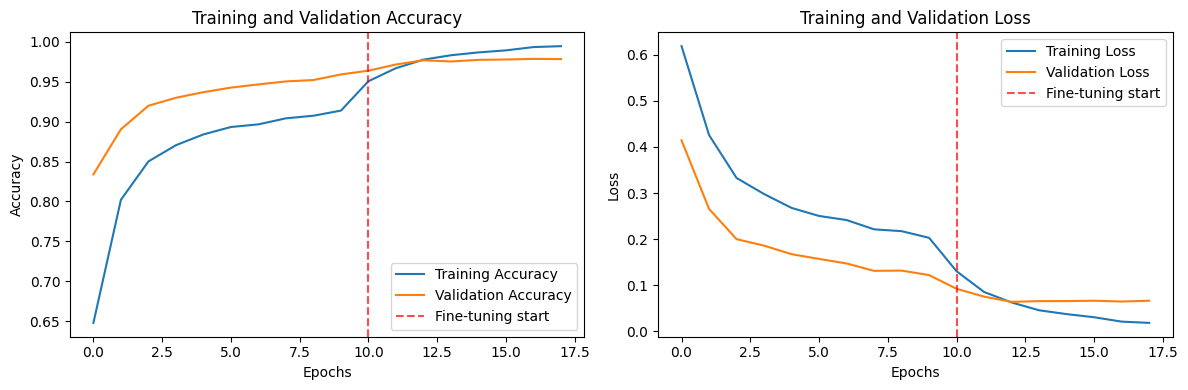

In [14]:
def plot_training_history(history1, history2):
    """
    Plota gráficos de loss e accuracy durante o treinamento
    """
    # Combinar históricos
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.axvline(x=len(history1.history['accuracy']), color='r', linestyle='--', alpha=0.7, label='Fine-tuning start')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.axvline(x=len(history1.history['loss']), color='r', linestyle='--', alpha=0.7, label='Fine-tuning start')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history_phase1, history_phase2)

AVALIAÇÃO DO MODELO

In [15]:
# Avaliação final
test_loss, test_accuracy = model.evaluate(validation_dataset, verbose=0)
print(f"\nAcurácia final no conjunto de validação: {test_accuracy:.4f}")
print(f"Loss final no conjunto de validação: {test_loss:.4f}")


Acurácia final no conjunto de validação: 0.9770
Loss final no conjunto de validação: 0.0639


SALVAMENTO DO MODELO

In [16]:
# Salvar o modelo treinado
model.save('cats_vs_dogs_transfer_learning-10k.keras')
print("\nModelo salvo como 'cats_vs_dogs_transfer_learning-10k.keras'")

# Para carregar o modelo posteriormente:
# loaded_model = keras.models.load_model('cats_vs_dogs_transfer_learning.keras')

print("\n" + "="*50)
print("PROJETO CONCLUÍDO COM SUCESSO!")
print("="*50)
print(f"Acurácia final: {test_accuracy:.4f}")
print("Modelo salvo e pronto para uso!")


Modelo salvo como 'cats_vs_dogs_transfer_learning-10k.keras'

PROJETO CONCLUÍDO COM SUCESSO!
Acurácia final: 0.9770
Modelo salvo e pronto para uso!
